<a href="https://colab.research.google.com/github/bragarods/rainfall_forecast/blob/master/notebooks/ts_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (11, 7)

## Import monthly data

In [2]:
# google drive shareable file link

orig_url = 'https://drive.google.com/file/d/1WQ9NARYCNZxWlQUAf4Zn5TxJcnOGjEn3/view?usp=sharing'

# get file id

file_id = orig_url.split('/')[-2]

# create download url

dwn_url='https://drive.google.com/uc?export=download&id=' + file_id

# get raw text inside url

url = requests.get(dwn_url).text

# create a buffer

csv_raw = StringIO(url)

# read from buffer

df = pd.read_csv(csv_raw, index_col=0)

df.reset_index(drop=True, inplace=True)

# create sinop and csinop series

df['date'] = pd.to_datetime(df['date'], format=('%Y-%m-%d')) 

#df.set_index('date', inplace=True)

# cut train period

train = df[(df.date >= '2000-01-01') & (df.date <= '2019-12-01')]

test = df[df.date >= '2019-01-01']

## Flag first full year of data

In [3]:
df['chuva_max_12m'] = df.groupby('cd_estacao')['chuva'].rolling(12).max().reset_index(0,drop=True)

df['flag_chuva_max_12m'] = np.where((~df['chuva_max_12m'].isna()) & (df['chuva_max_12m'] >= 1),
                               1,
                               0)

min_year = df[df['flag_chuva_max_12m']==1].groupby('cd_estacao').agg(min_year=('date','min'))['min_year'].dt.year+1

df = pd.merge(df,min_year,how='left',left_on=df.cd_estacao,right_on=min_year.index)

df.drop(columns='key_0', inplace=True)

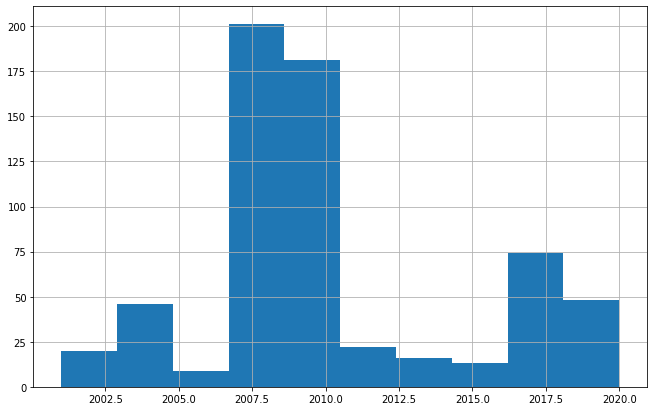

In [201]:
df.drop_duplicates(['cd_estacao']).min_year.hist()

## Clustering series

In [206]:
df10 = df[(df['min_year']<=2009) & (df.date >= '2009-01-01')]

In [208]:
dfp = df10.set_index('date').pivot(columns=['cd_estacao'], values=['chuva'])
dfp.columns = dfp.columns.droplevel()

In [209]:
from tslearn.datasets import CachedDatasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset


# define seed
seed = 0
np.random.seed(seed)

X, y = dfp[dfp.index<='2018-12-01'], dfp[dfp.index > '2018-12-01']

series = []

for col in dfp.columns:
  series.append(dfp[col])

X_train = to_time_series_dataset([s.values for s in series])

X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)

#X_train = X_train[y_train < 4]  # Keep first 3 classes
#numpy.random.shuffle(X_train)
# Keep only 50 time series
#X_train = TimeSeriesScalerMeanVariance().fit_transform(X)
# Make time series shorter
#X_train = TimeSeriesResampler(sz=40).fit_transform(X_train)
#sz = X_train.shape[1]

Euclidean k-means
121.920 --> 78.115 --> 76.282 --> 74.925 --> 74.224 --> 74.014 --> 73.872 --> 73.779 --> 73.774 --> 73.758 --> 73.738 --> 73.738 --> 


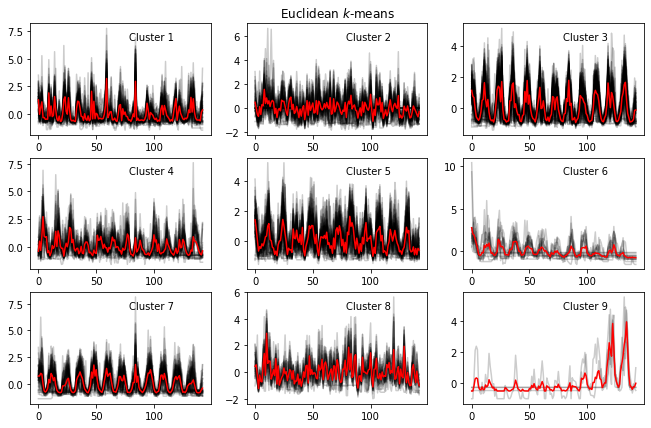

In [224]:
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=10, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)

plt.figure()
for yi in range(9):
    plt.subplot(3, 3, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    #plt.xlim(0, X_train.shape[1])
    #plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

In [225]:
from tslearn.metrics import cdist_dtw

for yi in np.arange(0,10):
  print(cdist_dtw(X_train[y_pred==yi]).mean())

7.279234633312274
8.709097195679364
6.774050565086273
7.4529819294584545
7.251253810602427
8.2797977220731
7.008395417580943
7.170548122936626
5.4854924731964125
6.688835807123242


DBA k-means
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


584076.669 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


432425.049 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


427137.690 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


424229.270 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


424229.270 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.6s finished


555325.730 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


428975.991 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


428975.991 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


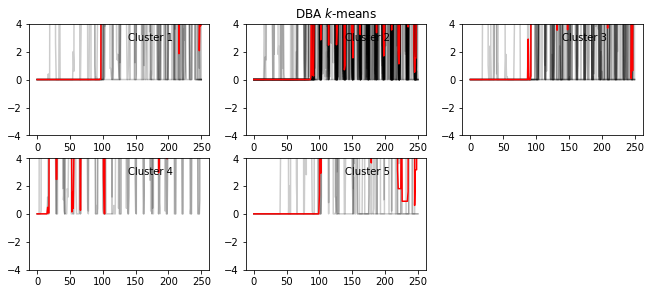

In [115]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=5,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(X_train)

for yi in range(5):
    plt.subplot(3, 3, 4 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    #plt.xlim(0, sz)
    #plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

Soft-DTW k-means
402107476144.291 --> 228845262320.792 --> 228715719321.222 --> 228614919395.713 --> 228405432541.201 --> 228337463072.049 --> 228178757251.933 --> 228134774892.517 --> 227997181964.666 --> 227963382314.981 --> 227580728441.034 --> 227529437484.235 --> 227493905221.291 --> 227381302478.524 --> 227358674047.171 --> 227291078729.013 --> 227274284559.461 --> 227262282613.917 --> 227252902720.132 --> 227224359845.215 --> 227203365063.163 --> 227123492886.753 --> 227111311054.270 --> 226961959062.693 --> 226939177437.379 --> 226933052357.031 --> 226930021880.422 --> 226928433326.911 --> 226928496757.061 --> 226930005243.465 --> 226933113856.871 --> 226937558170.403 --> 226944875381.419 --> 226943436484.111 --> 226955086761.506 --> 226952331524.125 --> 226954354803.571 --> 226952203159.306 --> 226957614857.439 --> 226955744515.323 --> 226980417392.938 --> 226974464611.521 --> 226979894528.999 --> 226980471535.747 --> 226983186752.057 --> 226983454977.074 --> 226980525913.987 

ValueError: ignored

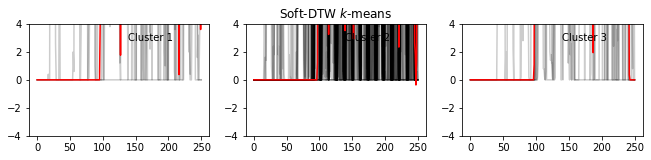

In [116]:
# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=5,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
y_pred = sdtw_km.fit_predict(X_train)

for yi in range(5):
    plt.subplot(3, 3, 7 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    #plt.xlim(0, sz)
    #plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

plt.tight_layout()
plt.show()

In [198]:
from tslearn.utils import to_time_series_dataset, to_pyts_dataset

fdf = pd.DataFrame(to_pyts_dataset(X_train))

fdf = fdf.set_index([y_pred,np.arange(0,50)]).sort_index()

In [188]:

#fdf[np.arange(0,51)] = 
pd.DataFrame(fdf[1].to_list())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250
0,-0.998647,-0.998647,-0.998647,-0.998647,-0.998647,-0.998647,-0.996858,-0.528133,-0.342074,0.890564,0.949602,-0.096978,-0.138126,-0.120235,0.801113,0.264405,-0.680200,-0.998647,-0.876993,-0.644420,-0.560336,0.210734,0.466565,-0.020050,0.906665,0.822581,0.087292,-0.179273,-0.839424,-0.998647,-0.846580,-0.835846,-0.461939,-0.309872,0.198211,2.137515,0.768910,0.185688,0.008574,-0.331340,...,-0.998647,-0.909196,-0.676622,1.987237,1.310985,0.421839,1.307407,1.040842,0.912032,-0.912774,-0.998647,-0.998647,-0.792909,-0.644420,1.446951,1.674157,0.785012,-0.599694,0.566750,1.162496,1.865583,-0.393956,-0.927086,-0.998647,-0.998647,-0.907407,-0.794698,0.890564,1.400436,1.783288,0.738497,1.531035,0.609687,-0.737449,-0.998647,-0.998647,-0.998647,-0.732082,0.514869,1.022952
1,-0.960032,-0.960032,-0.960032,-0.960032,-0.960032,-0.960032,-0.960032,-0.960032,-0.960032,-0.960032,-0.960032,-0.960032,-0.960032,-0.960032,-0.960032,-0.960032,-0.949323,-0.960032,-0.960032,-0.810102,0.223345,0.383984,1.506676,0.560688,0.505357,1.165763,1.053316,-0.667312,-0.924335,-0.960032,-0.960032,-0.861864,-0.638753,-0.588777,0.187647,1.338897,1.695873,1.371025,0.350072,0.398264,...,-0.960032,-0.779759,-0.347817,0.864118,1.329972,0.516066,1.138990,0.906955,0.234054,-0.876143,-0.960032,-0.960032,-0.792253,-0.620905,0.366136,0.660641,0.687415,-0.396009,1.033682,0.241194,1.404937,-0.563788,-0.960032,-0.956463,-0.960032,-0.792253,-0.279992,0.537484,0.994414,1.865437,3.032751,0.064490,0.105543,-0.876143,-0.960032,-0.960032,-0.960032,-0.951108,0.025223,0.524990
2,-0.756341,-0.756341,-0.756341,-0.756341,-0.756341,-0.756341,-0.756341,-0.756341,-0.756341,-0.756341,-0.756341,-0.756341,-0.756341,-0.756341,-0.756341,-0.756341,-0.706486,-0.737166,-0.756341,-0.551171,0.382639,0.284848,0.158295,1.839920,1.057591,1.849508,-0.307652,-0.608695,-0.719909,-0.756341,-0.704569,-0.739083,-0.177263,-0.384351,0.064339,1.352882,1.828415,1.400819,1.916619,-0.043040,...,-0.756341,-0.616365,-0.177263,2.399823,1.414241,1.450673,0.681765,0.238829,0.081596,-0.712239,-0.752506,-0.756341,-0.737166,-0.043040,0.449751,1.999071,0.614654,0.996231,0.769969,1.600236,0.179387,0.129533,-0.756341,-0.754423,-0.756341,-0.608695,-0.392020,0.842833,2.256012,1.205236,2.654847,0.334703,-0.355588,-0.670054,-0.756341,-0.756341,-0.756341,-0.673889,0.716280,0.683683
3,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.555086,-0.555086,-0.557103,-0.064897,1.232187,0.893291,2.878254,2.541375,1.028446,-0.486500,-0.208121,-0.216190,-0.571224,-0.559121,-0.571224,-0.450190,0.082361,0.953808,1.050636,-0.135501,-0.553069,-0.547017,-0.571224,...,-0.571224,-0.571224,-0.000346,1.209998,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224,-0.571224
4,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.386970,-0.391758,-0.391758,-0.051777,1.854036,3.281001,2.665682,5.433420,1.262659,1.480535,0.055964,-0.360633,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.252892,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,...,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.391758,-0.104450,1.324909,2.069517,2.945808,0.659312,2.263450,2.924260,0.549177,-0.3582

In [165]:
y_pred

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0])